<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/3_4_first_classifier_Train_new_sample_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding + first classifier

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler


In [4]:
data = pd.read_excel("2_full_data_with_predictions V2.xlsx")

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [5]:
data

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_custom_threshold,prediction_original_model,בקשה לרשות ערעור התקבלה?,טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**),הערעור התקבל?,"רע""פ בקשה אחרת או דלמטה מיוחד",קידוד,קידוד חוזר,הערות תוצאת ערעור,הערות,הערות קידוד חוזר
0,0,5424,"['החלטה בתיק רע""פ 245/04 בבית המשפט העליון רע""...","רע""פ 245/04","רע""פ 245/04 אשר אמר נ. מדינת ישראל",2004,"ט."" 3. המבקש עותר לאפשר לו להביא את עניינולדיו...",0.000160,0,0,נדחה,NaN,NaN,NaN,גל,דניאל,NaN,NaN,NaN
1,1,5425,"['החלטה בתיק רע""פ 11196/04 בבית המשפט העליון ר...","רע""פ 11196/04","רע""פ 11196/04",2004,"['החלטה בתיק רע""פ 11196/04 בבית המשפט העליון ר...",0.024509,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5426,"['החלטה בתיק רע""פ 6526/04 בבית המשפט העליון בש...","רע""פ 6526/04","רע""פ 6526/04 גולנ עמיקמ נ. מדינת ישראל",2004,תי ערכאות – אינן מעוררות שאלה מעיןזו. מנימוק ז...,0.000010,0,0,נדחה,NaN,NaN,NaN,גל,דניאל,NaN,NaN,NaN
3,3,5427,"['החלטה בתיק רע""פ 2444/04 בבית המשפט העליון רע...","רע""פ 2444/04","רע""פ 2444/04 פריד אלקצאצי נ. מדינת ישראל",2004,"כן רע""פ 1174/97 עזרא רפאלי נ\' מדינת ישראל (לא...",0.002376,0,0,נדחה,NaN,NaN,NaN,גל,דניאל,NaN,NaN,NaN
4,4,5428,"['החלטה בתיק רע""פ 2377/04 בבית המשפט העליון בש...","רע""פ 2377/04","רע""פ 2377/04 דני רוזנ נ. היועצ המשפטי לממשלה",2004,"יטב. עניינו של המבקש, אשר נדוןבשתי ערכאות, אינ...",0.003917,0,0,נדחה,NaN,NaN,NaN,גל,דניאל,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,1424,20605,"['החלטה בתיק רע""פ 7505/21 בבית המשפט העליון רע...","רע""פ 7505/21","רע""פ 7505/21 טל גויחמו נ. מדינת ישראל",2021,"סעיף 8 לחוק הפלת""ד חוסם את דרכו של נפגע בתאונת...",0.044445,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1411,1425,20606,"['החלטה בתיק רע""פ 513/21 בבית המשפט העליון רע""...","רע""פ 513/21","רע""פ 513/21 עידנ יהושע נ. מדינת ישראל",2021,וד השופט ג\' קרא המבקש: עידן יהושע נגד המשיבה:...,0.015734,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1412,1426,20607,"['החלטה בתיק רע""פ 225/21 בבית המשפט העליון רע""...","רע""פ 225/21","רע""פ 225/21 אלקאר דביר בע""מ נ. מדינת ישראל",2021,על קביעות שבעובדה באשר לאופן שליחת הודעות הקנס...,0.000667,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1413,1427,20608,"['החלטה בתיק רע""פ 4075/21 בבית המשפט העליון רע...","רע""פ 4075/21","רע""פ 4075/21 דב הרמנ נ. מדינת ישראל",2021,"ו חמור יתר על המידה, אך אינו טוען במפורש כי הו...",0.000381,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data['רע"פ בקשה אחרת או דלמטה מיוחד'].value_counts()
data[(data['רע"פ בקשה אחרת או דלמטה מיוחד'] == 'בקשה אחרת') | (data['רע"פ בקשה אחרת או דלמטה מיוחד'] == 'דלמטה מיוחד')].shape[0]

41

In [7]:
data = data[(data['רע"פ בקשה אחרת או דלמטה מיוחד'] != 'בקשה אחרת') & (data['רע"פ בקשה אחרת או דלמטה מיוחד'] != 'דלמטה מיוחד')]

In [8]:
data = data[(data['בקשה לרשות ערעור התקבלה?'] != 'חלקי') & (data['בקשה לרשות ערעור התקבלה?'] != 'אחר')]

In [9]:
data.dropna(subset=['בקשה לרשות ערעור התקבלה?'],inplace=True)

In [10]:
data['binary_outcome'] = data['בקשה לרשות ערעור התקבלה?'].apply(lambda x: 1 if x == 'התקבל' else 0)

In [11]:
data.shape[0]

158

Confusion Matrix:
[[124   1]
 [ 22  11]]


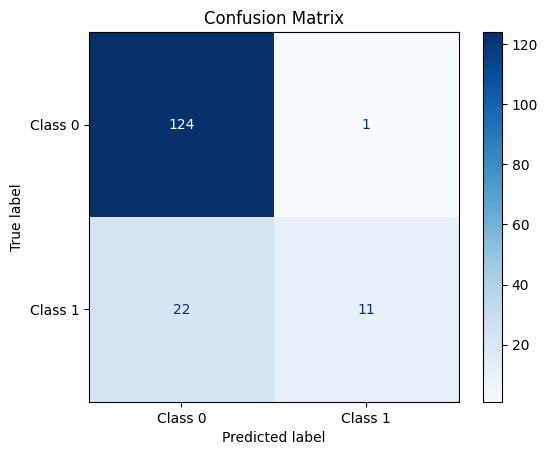

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# יצירת confusion matrix
cm = confusion_matrix(data['binary_outcome'], data['prediction_original_model'])

# הצגת תוצאות confusion matrix
print("Confusion Matrix:")
print(cm)

# ויזואליזציה של confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [13]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import joblib
import pandas as pd

# טעינת המודל והטוקנייזר
tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.86M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

### Embedding

In [ ]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_predict, cross_validate
import joblib


# עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
y = data["binary_outcome"].values
embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])


### Train and fit

In [ ]:
X = embeddings
# טוען את המודל
classifier = joblib.load("classifier_model_second_undersampled.pkl")

print("המודל נטען בהצלחה.")

# התאמת המודל לנתונים המאוזנים
classifier.fit(X, y)

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X, y, cv=5)
conf_matrix = confusion_matrix(y, y_pred)

# הדפסת התוצאות
print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")


# --- שמירת משאבים ---
joblib.dump(classifier, 'classifier_model_double_trained.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")


In [ ]:
# חיזוי הסתברויות לכל קפל לצורך שינוי סף
y_prob = cross_val_predict(classifier, X, y, cv=5, method='predict_proba')[:, 1]

# קביעת סף חדש
threshold = 0.1
y_pred = (y_prob >= threshold).astype(int)

# יצירת קונפיושן מטריקס
conf_matrix = confusion_matrix(y, y_pred)
# חישוב מדדים עם הסף החדש
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, pos_label=1)
recall = recall_score(y, y_pred, pos_label=1)
f1 = f1_score(y, y_pred, pos_label=1)

print("\nמדדים לאחר שינוי סף הסיווג:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision for Class 1: {precision:.3f}")
print(f"Recall for Class 1: {recall:.3f}")
print(f"F1 Score for Class 1: {f1:.3f}")

# # הדפסת התוצאות
# print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
# print("Mean Accuracy:", cv_results['test_accuracy'].mean())
# print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
# print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
# print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
# print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
# print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
# print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")

# --- שמירת משאבים ---
joblib.dump(classifier, 'classifier_model_double_trained.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")

### FN print


In [ ]:

# איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
fn_indices = np.where((y == 1) & (y_pred == 0))[0]


# קריאת השורות הרלוונטיות מה-DataFrame
false_negative_rows = data.iloc[fn_indices]

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_negative_rows) != len(fn_indices):
    raise ValueError("Mismatch between FN rows and FN indices!")

# הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Negative Cases (True Label: 1, Predicted Label: 0):")
print("=" * 80)

for i, (index, row) in enumerate(false_negative_rows.iterrows(), 1):
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)

    # הדפסת binary_outcome (תווית אמיתית)
    print("\nBinary Outcome (True Label):")
    print(row["binary_outcome"])

    # הדפסת התחזית (Predicted Label)
    print("\nPredicted Label:")
    print(0)  # FN משמעותו שהתחזית היא 0

    # הדפסת גוף המסמך אם קיים
    if "גוף המסמך" in row:
        print("\nDocument Body:")
        formatted_text = "\n".join(row["גוף המסמך"][j:j + 80] for j in range(0, len(row["גוף המסמך"]), 80))
        print(formatted_text)
    else:
        print("\nDocument Body: Not Available")

    # הדפסת גוף המסמך חתוך אם קיים
    if "גוף המסמך חתוך" in row:
        print("\nDocument Body (Trimmed):")
        formatted_text_trimmed = "\n".join(row["גוף המסמך חתוך"][j:j + 80] for j in range(0, len(row["גוף המסמך חתוך"]), 80))
        print(formatted_text_trimmed)
    else:
        print("\nDocument Body (Trimmed): Not Available")

    # הדפסת שאר העמודות הרלוונטיות
    relevant_columns = [
        "בקשה לרשות ערעור התקבלה?", "טקסט שמצביע על תוצאת בקשה שונה",
        "הערעור התקבל?", "רע\"פ בקשה אחרת או דלמטה מיוחד",
        "קידוד", "קידוד חוזר", "הערות", "הערות קידוד חוזר"
    ]
    print("\nRelevant Columns Data:")
    for col in relevant_columns:
        if col in row:
            print(f"{col}: {row[col]}")
        else:
            print(f"{col}: Not Available")

    print("-" * 80)

print("=" * 80)


In [ ]:
# חיזוי תוויות על כל קפל לצורך זיהוי FP
y_pred = cross_val_predict(classifier, X, y, cv=5)

# איתור האינדקסים של FP - תווית אמיתית היא 0 והתחזית היא 1
fp_indices = np.where((y == 0) & (y_pred == 1))[0]


# קריאת השורות הרלוונטיות מה-DataFrame
false_positive_rows = data.iloc[fp_indices]

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_positive_rows) != len(fp_indices):
    raise ValueError("Mismatch between FP rows and FP indices!")

# הדפסת פסקי הדין של FP בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Positive Cases (True Label: 0, Predicted Label: 1):")
print("=" * 80)

for i, (index, row) in enumerate(false_positive_rows.iterrows(), 1):
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)

    # הדפסת binary_outcome (תווית אמיתית)
    print("\nBinary Outcome (True Label):")
    print(row["binary_outcome"])

    # הדפסת התחזית (Predicted Label)
    print("\nPredicted Label:")
    print(1)  # FP משמעותו שהתחזית היא 1

    # הדפסת גוף המסמך אם קיים
    if "גוף המסמך" in row:
        print("\nDocument Body:")
        formatted_text = "\n".join(row["גוף המסמך"][j:j + 80] for j in range(0, len(row["גוף המסמך"]), 80))
        print(formatted_text)
    else:
        print("\nDocument Body: Not Available")

    # הדפסת גוף המסמך חתוך אם קיים
    if "גוף המסמך חתוך" in row:
        print("\nDocument Body (Trimmed):")
        formatted_text_trimmed = "\n".join(row["גוף המסמך חתוך"][j:j + 80] for j in range(0, len(row["גוף המסמך חתוך"]), 80))
        print(formatted_text_trimmed)
    else:
        print("\nDocument Body (Trimmed): Not Available")

    # הדפסת שאר העמודות הרלוונטיות
    relevant_columns = [
        "בקשה לרשות ערעור התקבלה?", "טקסט שמצביע על תוצאת בקשה שונה",
        "הערעור התקבל?", "רע\"פ בקשה אחרת או דלמטה מיוחד",
        "קידוד", "קידוד חוזר", "הערות", "הערות קידוד חוזר"
    ]
    print("\nRelevant Columns Data:")
    for col in relevant_columns:
        if col in row:
            print(f"{col}: {row[col]}")
        else:
            print(f"{col}: Not Available")

    print("-" * 80)

print("=" * 80)


Undersampling

In [ ]:

# הגדרת undersampler עם יחס של60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# שמירת אינדקסים מקוריים
resampled_indices = undersampler.sample_indices_
joblib.dump(resampled_indices, 'resampled_indices.pkl')

# ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values
if not np.array_equal(y_resampled, binary_outcome_resampled):
    raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
classifier = joblib.load("classifier_model.pkl")

# התאמת המודל לנתונים המאוזנים
classifier.fit(X_resampled, y_resampled)

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X_resampled, y_resampled, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)
conf_matrix = confusion_matrix(y_resampled, y_pred)

# הדפסת התוצאות
print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")

# --- לוגיקה למציאת threshold אופטימלי ---
predicted_probabilities = classifier.predict_proba(X_resampled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_resampled, predicted_probabilities)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Threshold אופטימלי לפי F1 Score: {optimal_threshold}")

# שמירת יחס הכיתות המקורי
class_ratio_original = sum(y == 1) / len(y)
print(f"יחס כיתות מקורי (Class 1): {class_ratio_original:.2f}")

# --- שמירת משאבים ---
joblib.dump(classifier, 'classifier_model_second_undersampled.pkl')
joblib.dump(optimal_threshold, 'optimal_threshold.pkl')
joblib.dump(class_ratio_original, 'class_ratio_original.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")


In [ ]:
# חיזוי הסתברויות לכל קפל לצורך שינוי סף
y_prob = cross_val_predict(classifier, X, y, cv=5, method='predict_proba')[:, 1]

# קביעת סף חדש
threshold = 0.1
y_pred = (y_prob >= threshold).astype(int)

# יצירת קונפיושן מטריקס
conf_matrix = confusion_matrix(y, y_pred)
# חישוב מדדים עם הסף החדש
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, pos_label=1)
recall = recall_score(y, y_pred, pos_label=1)
f1 = f1_score(y, y_pred, pos_label=1)

print("\nמדדים לאחר שינוי סף הסיווג:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision for Class 1: {precision:.3f}")
print(f"Recall for Class 1: {recall:.3f}")
print(f"F1 Score for Class 1: {f1:.3f}")

# # הדפסת התוצאות
# print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
# print("Mean Accuracy:", cv_results['test_accuracy'].mean())
# print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
# print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
# print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
# print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
# print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
# print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")

# --- שמירת משאבים ---
joblib.dump(classifier, 'classifier_model_second_undersampled.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")